In [1012]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import calendar
from time import gmtime, strftime
import time
import urllib2,cookielib
import pickle
import re
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from ggplot import *
import vincent
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from scipy import optimize
from bs4 import BeautifulSoup
pd.set_option('max_colwidth', 9000)
pd.set_option('max_columns', 100)
%matplotlib inline
import vincent
vincent.core.initialize_notebook()

In [947]:
lc = pd.read_csv('/Users/mritchie712/blis/lc/LCData2012.csv')

In [948]:
lc2 = pd.read_csv('/Users/mritchie712/blis/lc/LCData2013.csv')

In [949]:
lc2 = lc.append(lc2)

In [950]:
lc2 = lc2[lc2.id.isnull()==False]
# lc2 = lc2[lc2.issue_d.str.contains('2014')==False]
lc2 = lc2.reset_index()
lc2['emp_title'] = lc2.emp_title.str.lower()
lc2['intercept'] = 1
lc2['yib'] = lc2.emp_length.str.replace('years','')
lc2['yib'] = lc2.yib.str.replace('< 1 year','0')
# lc2['yib'] = lc2.yib.str.replace('<','0')
lc2['yib'] = lc2.yib.str.replace('year','')
lc2['yib'] = lc2.yib.str.replace('+','')
lc2['yib'] = lc2.yib.str.replace('n/a','0')
lc2['yib'] = lc2.yib.fillna(0)
lc2['yib'] = lc2.yib.astype(int)
lc2['loan_status'] = lc2.loan_status.astype(str)
lc2['bad'] = 0
lc2.loc[lc2.loan_status.str.contains('Late'),'bad'] = 1
lc2.loc[lc2.loan_status.str.contains('Charged Off'),'bad'] = 1
lc2.loc[lc2.loan_status.str.contains('Default'),'bad'] = 1
lc2.loc[lc2.loan_status.str.contains('nan'),'bad'] = 1
lc2['co'] = 0
lc2.loc[lc2.loan_status.str.contains('Charged Off'),'co'] = 1
lc2['good'] = 1
lc2.loc[lc2.bad==1,'good'] = 0
lc2['inq_last_6mths'] = lc2.inq_last_6mths.fillna(0)
lc2.loc[lc2.inq_last_6mths>10,'inq_last_6mths'] = 10
lc2['sb'] = lc2.purpose=='small_business'
lc2['dti'] = lc2.dti.fillna(0)
lc2.loc[lc2.annual_inc>300000,'annual_inc'] = 300000
lc2['annual_inc'] = lc2.annual_inc.fillna(0)
lc2['revol_util'] = lc2.revol_util.str.replace('%','').astype(float)
lc2['earliest_cr_line'] = pd.to_datetime(pd.Series(lc2.earliest_cr_line))
#(datetime.datetime.now() - lc2.earliest_cr_line)
gradeDummies = pd.get_dummies(lc2.grade, prefix='grade')
lc2 = pd.merge(lc2, gradeDummies, left_index = True, right_index=True)

In [951]:
dtNow=datetime.utcnow()
dts = pd.to_datetime(lc2.issue_d)
oYrLs=[]
oMoLs=[]
for dt in dts:
    oYr = 2000+dt.day
    oMo = dt.month
    oYrLs.append(oYr)
    oMoLs.append(oMo)
lc2['oYr'] = oYrLs
lc2['oMo'] = oMoLs
lc2['oDt'] = pd.to_datetime(lc2.oYr*10000 + lc2.oMo*100 + 1, format='%Y%m%d')
lc2['age'] = dtNow - lc2['oDt']
dts = pd.to_datetime(lc2.last_pymnt_d)
oYrLs=[]
oMoLs=[]
for dt in dts:
    oYr = 2000+dt.day
    oMo = dt.month
    oYrLs.append(oYr)
    oMoLs.append(oMo)
lc2['pYr'] = oYrLs
lc2['pMo'] = oMoLs
lc2['pDt'] = pd.to_datetime(lc2.pYr*10000 + lc2.pMo*100 + 1, format='%Y%m%d')
lc2['pAge'] = dtNow - lc2['pDt']

In [952]:
ageMoLs=[]
for age in lc2['age'].tolist():
    try:
        ageMoLs.append(age.days/30)
    except:
        ageMoLs.append(999)
lc2['ageMo'] = ageMoLs

In [953]:
ageBadLs=[]
for age in lc2['pAge'].tolist():
    try:
        ageBadLs.append(age.days/30)
    except:
        ageBadLs.append(999)
lc2['pAgeMo'] = ageBadLs

In [954]:
lc2=lc2[lc2.ageMo<999]

In [955]:
lc2['bAgeMo'] = 0
lc2.loc[lc2.bad == 1, 'bAgeMo'] = lc2.ageMo - lc2.pAgeMo
lc2=lc2[lc2.bAgeMo>=0]

In [956]:
lc2['cAgeMo'] = 999
lc2.loc[lc2.co == 1, 'cAgeMo'] = lc2.bAgeMo + 4
lc2=lc2[lc2.cAgeMo>=0]

In [957]:
maxAge = lc2.ageMo.max()

In [971]:
lc2['emp_title'].fillna('missing', inplace=True)
lc2['emp_title2'] = lc2['emp_title'].str.replace('[^\w\s]','')
lc2['emp_title2'] = lc2['emp_title2'].str.replace(' ','')
lc2['emp_title2'] = lc2['emp_title2'].str.strip()
lc2['emp_title2'] = lc2['emp_title2'].str.replace('unitedstatespostalservice','usps')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('uspostalservice','usps')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('unitedparcelservice','usps')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('unitedstatesairforce','usaf')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('usairforce','usaf')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('comcastcable','comcast ')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('verizonwireless','verizon ')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('departmentofhomelandsecurity','homelandsecurity ')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('wellsfargobank','wellsfargo ')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('attorney','lawyer ')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('rn','nurse')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('registerednurse','nurse')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('truckdriver','driver')
lc2['emp_title2'] = lc2['emp_title2'].str.replace('truckdriver','driver')
top30Emp = lc2.emp_title2.value_counts()[1:31].index.tolist()

In [972]:
# lc2[lc2.emp_title2=='attonurseey']

In [974]:
lc2.emp_title2.value_counts()[:30]

missing                    24938
nurse                       6803
teacher                     6761
manager                     6134
driver                      3946
supervisor                  2987
sales                       2555
owner                       2509
projectmanager              1933
officemanager               1901
generalmanager              1752
director                    1339
engineer                    1302
policeofficer               1164
vicepresident               1144
usps                        1126
president                   1113
storemanager                1103
operationsmanager           1076
salesmanager                1072
administrativeassistant     1005
accountant                   946
technician                   942
lawyer                       941
usarmy                       881
accountmanager               847
mechanic                     844
assistantmanager             836
executiveassistant           743
analyst                      694
dtype: int

In [978]:
empBad = pd.pivot_table(lc2[lc2.emp_title2.isin(top30Emp)], 
                        values='bad', index='emp_title2',aggfunc=np.mean)
empBad = empBad.sort(inplace=False, ascending=False)
bar = vincent.Bar(empBad)
bar.axes[0].properties = vincent.AxisProperties(
    labels=vincent.PropertySet(
        angle=vincent.ValueRef(value=90),
        align=vincent.ValueRef(value='left')))
bar

In [980]:
empInc = pd.pivot_table(lc2[lc2.emp_title2.isin(top30Emp)], 
                        values='annual_inc', index='emp_title2',aggfunc=np.mean)
empInc = empInc.sort(inplace=False, ascending=False)
bar = vincent.Bar(empInc)
bar.axes[0].properties = vincent.AxisProperties(
    labels=vincent.PropertySet(
        angle=vincent.ValueRef(value=90),
        align=vincent.ValueRef(value='left')))
bar

In [984]:
empInc = pd.DataFrame(empInc)
empBad = pd.DataFrame(empBad)
empDF = empBad.join(empInc)

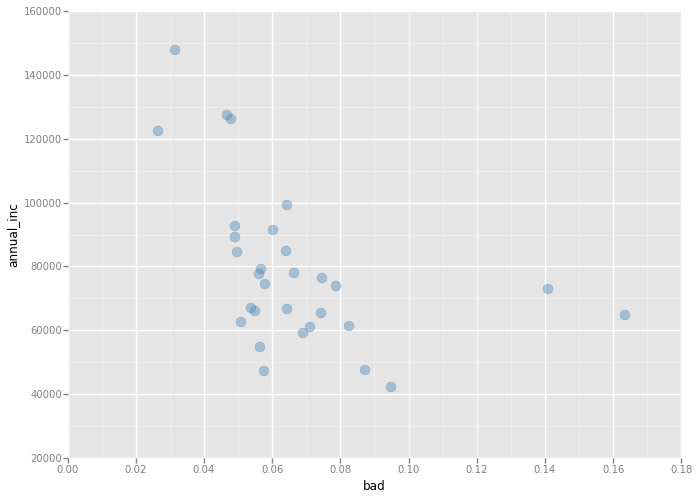

<ggplot: (1025693613)>

In [1025]:
# ggplot(empDF, aes(x='bad', y='annual_inc')) + geom_point(alpha=1)
ggplot(empDF, aes(x='bad', y='annual_inc')) + geom_point(color='steelblue', size=100, alpha=0.4)

In [1029]:
empDF.loc['teacher']

bad               0.050880
annual_inc    62718.221241
Name: teacher, dtype: float64

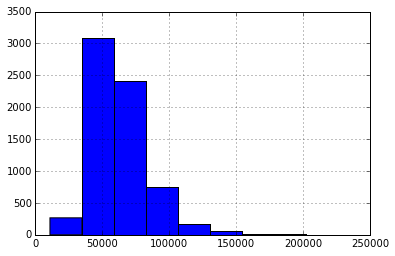

In [1031]:
lc2[lc2.emp_title2=='teacher'].annual_inc.hist()

In [1085]:
stLs=[]
for x in top30Emp:
    temp = [x, lc2[lc2.emp_title2==x].annual_inc.std(),lc2[lc2.emp_title2==x].annual_inc.mean()]
    stLs.append(temp)
stDF = pd.DataFrame(stLs)
stDF.columns = ['emp_title','stAnnInc','mAnnInc']
stDF['prcntStDev']=stDF.stAnnInc/stDF.mAnnInc
stDF = stDF.sort('stAnnInc')
# stDF = stDF.set_index('emp_title')

In [1086]:
stDF

,emp_title,stAnnInc,mAnnInc,prcntStDev
29,customerservice,15277.139195,42347.986484,0.360752
19,administrativeassistant,16871.764867,47273.608179,0.356896
26,assistantmanager,19673.383325,47590.332010,0.413390
14,usps,20585.297392,64763.098917,0.317855
8,officemanager,21249.637417,54659.613093,0.388763
1,teacher,21647.714151,62718.221241,0.345158
27,executiveassistant,22309.067918,66944.126016,0.333249
3,driver,22418.913099,61398.316384,0.365139
21,technician,23166.812296,59076.451656,0.392150
25,mechanic,24338.028510,60984.162405,0.399088


['customerservice',
 'administrativeassistant',
 'assistantmanager',
 'usps',
 'officemanager',
 'teacher',
 'executiveassistant',
 'driver',
 'technician',
 'mechanic',
 'usarmy',
 'accountant',
 'storemanager',
 'nurse',
 'supervisor',
 'policeofficer',
 'analyst',
 'operationsmanager',
 'engineer',
 'projectmanager',
 'accountmanager',
 'manager',
 'sales',
 'generalmanager',
 'salesmanager',
 'owner',
 'lawyer ',
 'director',
 'president',
 'vicepresident']

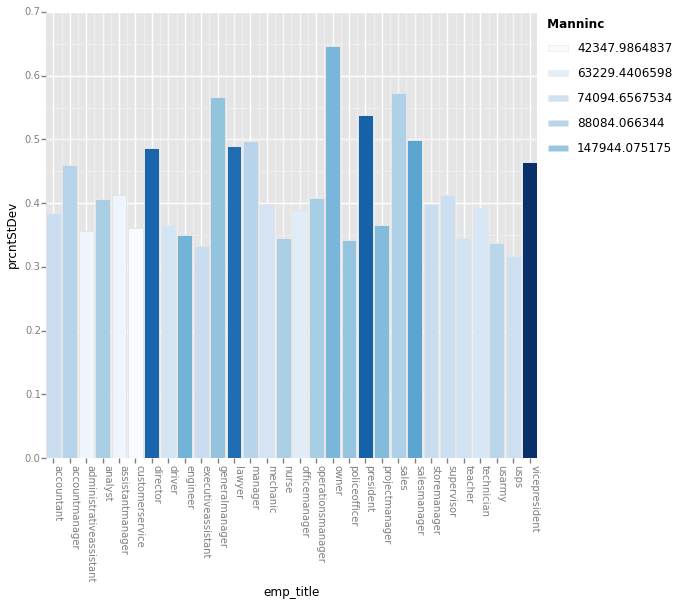

<ggplot: (1039036961)>

In [1102]:
p = ggplot(aes(y='prcntStDev',x='emp_title', fill='mAnnInc'), data=stDF) + \
    geom_bar(stat="bar") + \
    theme(axis_text_x=element_text(angle = -90, hjust = 0)) 
#     scale_x_discrete(limits=stDF.emp_title.tolist())
p

In [990]:
import random
cats = ['y' + str(x) for x in range(0, 12, 1)]
index = range(1, 21, 1)
data = {'index': index}
for cat in cats:
    data[cat] = [random.randint(10, 100) for x in index]

In [917]:
lc2 = lc2[lc2.ageMo>=24]

In [918]:
perf=pd.DataFrame()
for age in range(maxAge):
    piv = pd.pivot_table(lc2[lc2.cAgeMo>=age], values=['loan_amnt'], index=['fico_range_low'],aggfunc=[np.sum])['sum']
#     print piv
    piv2 = pd.pivot_table(lc2[(lc2.bad==1)&(lc2.bAgeMo<=age)&(lc2.cAgeMo>=age)], values=['loan_amnt'], 
                          index=['fico_range_low'],aggfunc=[np.sum])['sum']
    piv3 = pd.pivot_table(lc2[(lc2.loan_status=='Charged Off')&(lc2.cAgeMo==age)], 
                          values=['loan_amnt'], index=['fico_range_low'],aggfunc=[np.sum])['sum']
    piv3.columns = ['loan_amnt_c']
    piv = piv.join(piv2,lsuffix='_t',rsuffix='_b')
    piv = piv.join(piv3)
    piv['age'] = age
    perf = perf.append(piv)

In [919]:
perf = perf.fillna(0)
perf = perf.reset_index()

In [920]:
# perf2 = perf.set_index(keys=['age','fico_range_low'])
perf = perf.set_index(keys=['age'])

In [921]:
perf['lossRate'] = perf.loan_amnt_c / perf.loan_amnt_t
perf['badRate'] = perf.loan_amnt_b / perf.loan_amnt_t

In [923]:
# correalate early dlq with yr2 loss rate
# point in time 3, 6, 9, 12 mo dlq for loans >= 24 mos aged
# calc yr 2 loss for each band

In [924]:
perf2=perf.reset_index()

In [925]:
pivC = pd.pivot_table(perf2[(perf2.age>0)&(perf2.age<24)], values=['loan_amnt_c'], 
                     index='fico_range_low',margins=False,aggfunc=np.sum)

In [926]:
pivB = pd.pivot_table(perf2[(perf2.age>0)&(perf2.age<24)], values=['loan_amnt_t'], 
                     index='fico_range_low',margins=False,aggfunc=np.mean)

In [927]:
yr2loss = pivC.join(pivB)

In [928]:
yr2loss['lossRate'] = yr2loss.loan_amnt_c / yr2loss.loan_amnt_t

In [929]:
# yr2loss.lossRate.plot()
line = vincent.Bar(yr2loss.lossRate)
# line.axes['x'] = vincent.Axis(type='x', scale='x', values=yr2loss.index.tolist() )
line

In [26]:
ficosHiLoss = yr2loss[(yr2loss.lossRate<.11)&(yr2loss.lossRate>.08)].index.tolist()

In [27]:
perf3 = perf[perf.fico_range_low.isin(ficosHiLoss)]

In [75]:
piv = pd.pivot_table(perf3, values=['badRate'], 
                     index=perf3.index,margins=False,aggfunc=np.sum)
# piv = piv['sum']['lossRate']
piv.columns=['upper']
piv['lower'] = piv.upper*.8
# piv[piv.index<19].plot(legend=False,title='dlq curve to get under 10% yr2 loss')

In [53]:
line = vincent.Line(piv[piv.index<19])
# line.axis_titles(x='Months', y='Bad Rate')
line

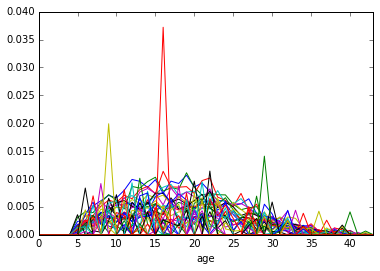

In [191]:
piv = pd.pivot_table(perf, values=['lossRate'], 
                     index=perf.index,columns='fico_range_low',margins=False,aggfunc=[np.sum])
piv = piv['sum']['lossRate']
piv.plot(legend=False)

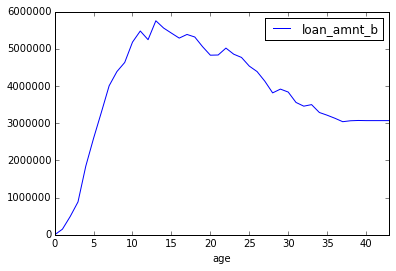

In [186]:
perf[perf.fico_range_low == 680][['loan_amnt_b']].plot()

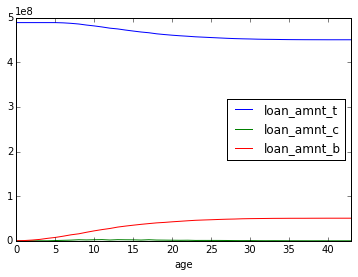

In [112]:
perf[perf.fico_range_low == 680][['loan_amnt_t','loan_amnt_c','loan_amnt_b']].plot()

/Users/mritchie712/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


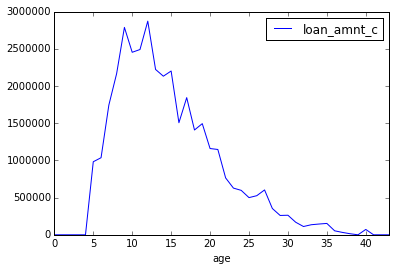

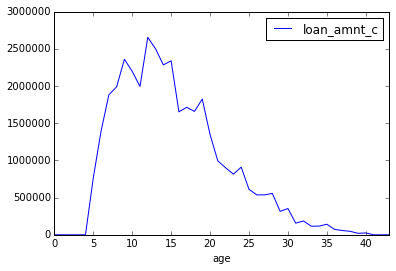

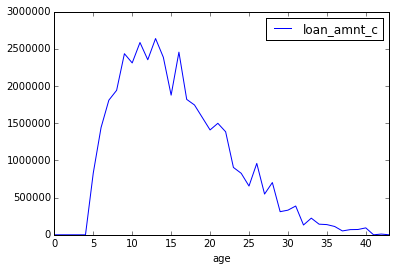

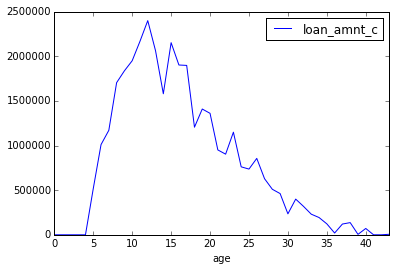

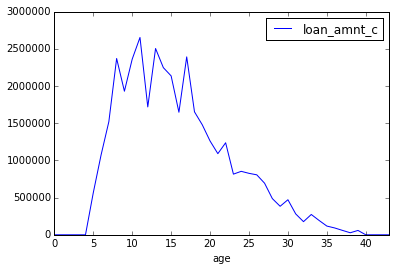

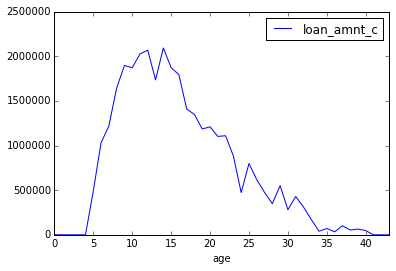

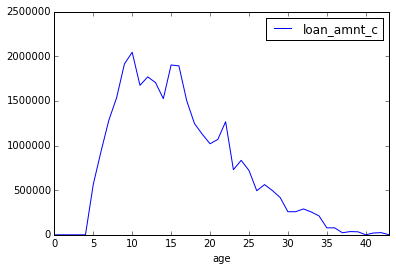

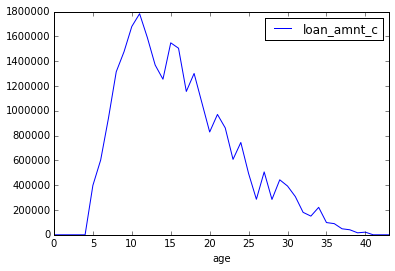

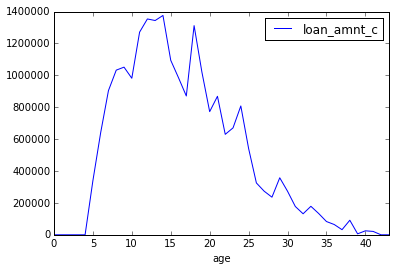

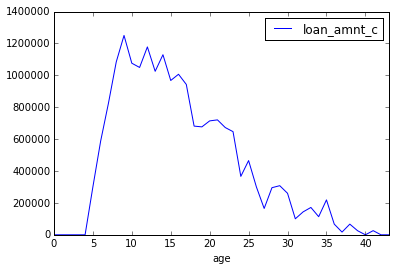

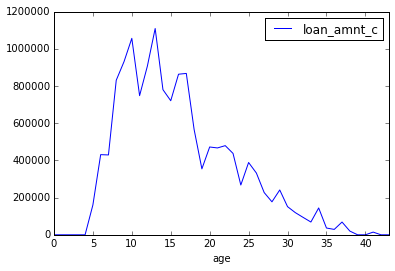

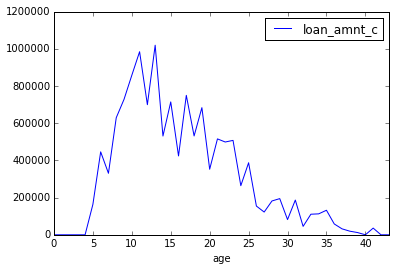

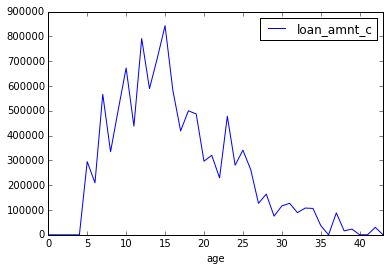

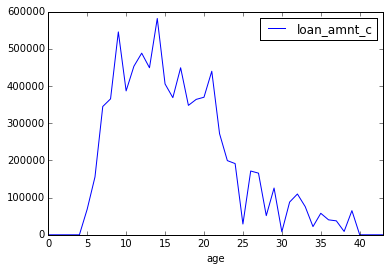

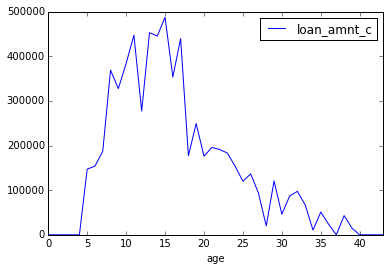

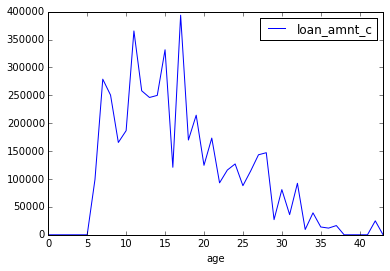

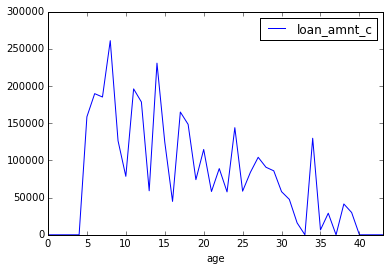

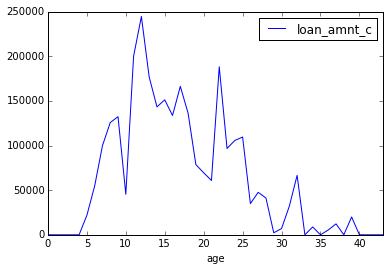

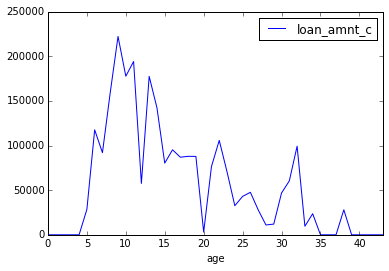

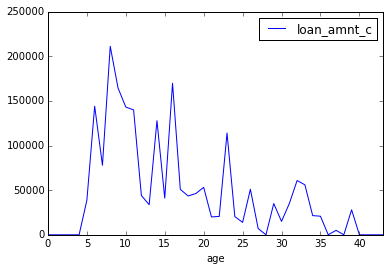

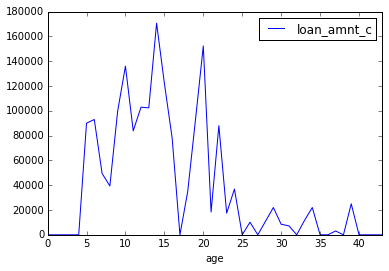

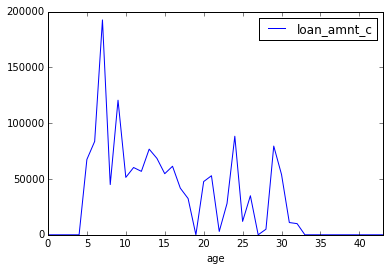

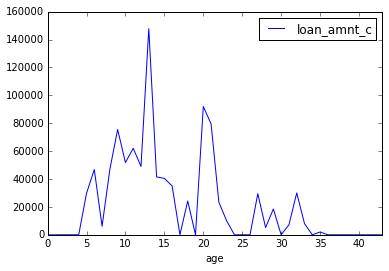

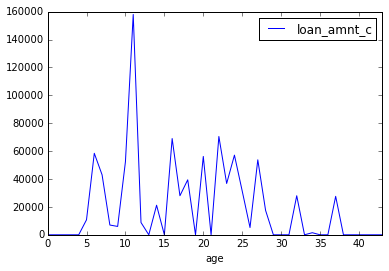

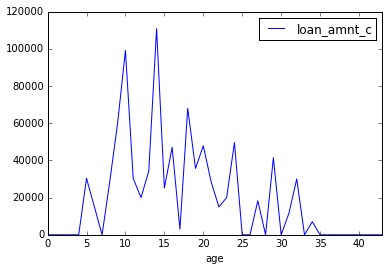

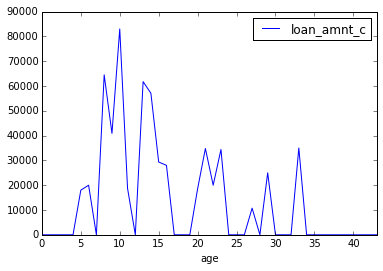

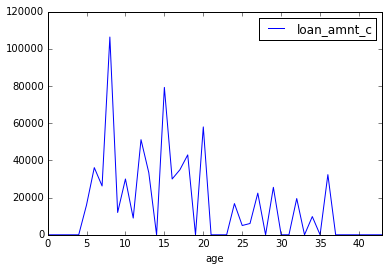

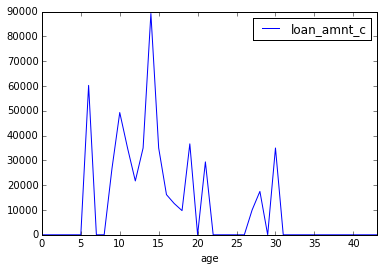

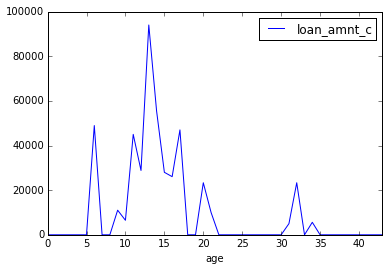

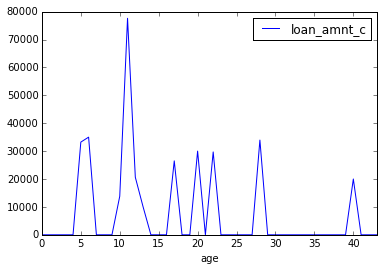

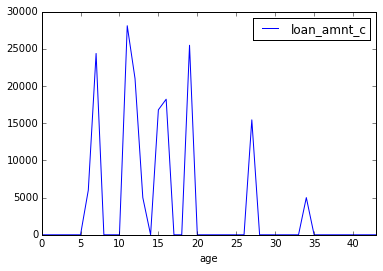

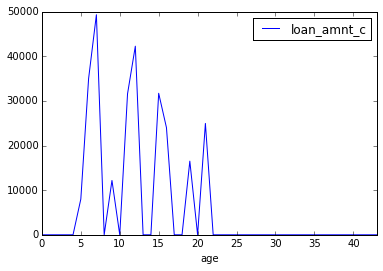

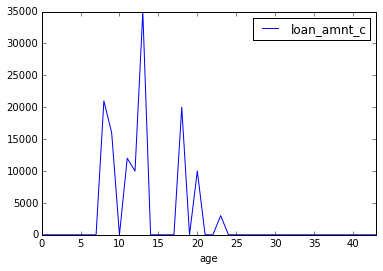

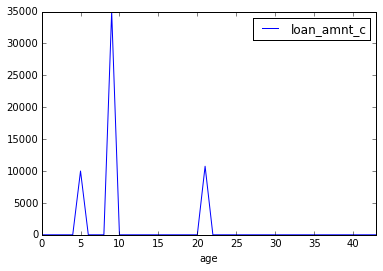

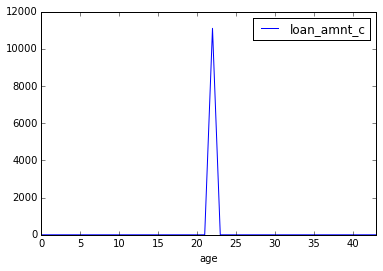

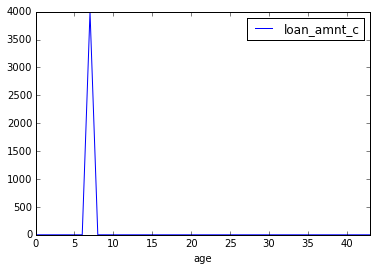

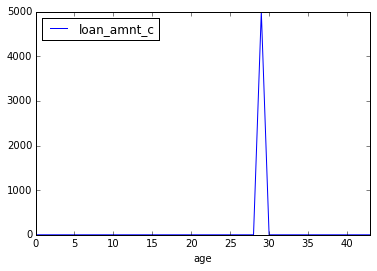

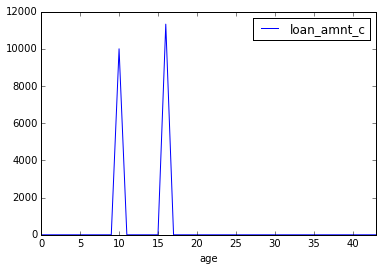

In [114]:
ficos = perf.fico_range_low.unique().tolist()
for fico in ficos:
    perf[perf.fico_range_low == fico][['loan_amnt_c']].plot()

In [930]:
len(lc2[lc2.ageMo>=24])

144186

In [157]:
lc2[lc2.oYr==2014].ageMo.value_counts()

11    38756
14    29293
10    25040
16    19089
17    19059
13    18798
15    17169
18    16501
20    15619
19    15263
12    10598
9     10301
dtype: int64

In [163]:
pd.pivot_table(lc2, values=['intercept'], index=['purpose'],margins=True,aggfunc=[np.sum])
pd.pivot_table(lc2, values=['bad'], index=['fico_range'],margins=True,aggfunc=[np.mean])

,mean
,bad
loan_status,
Charged Off,1.000000
Current,0.000000
Default,1.000000
Fully Paid,0.000000
In Grace Period,0.000000
Late (16-30 days),1.000000
Late (31-120 days),1.000000
All,0.084488


In [72]:
inq = inq.reset_index()
inq = inq.set_index(inq.fico_range_low.astype(str))

In [96]:
# pd.pivot_table(lc2, values=['intercept'], index=['fico_range_low'],colo,margins=True,aggfunc=[np.sum])
# pd.pivot_table(lc2, values=['bad'], index=['fico_range_low'],margins=True,aggfunc=[np.mean])
inq = pd.pivot_table(lc2[(lc2.ageMo>=24)&(lc2.inq_last_6mths <4)&(lc2.fico_range_low<730)], 
                     values='bad', index='fico_range_low',columns='inq_last_6mths',margins=False,aggfunc=np.mean)
newCols=[]
for col in inq.columns:
    col2 = 'inq = '+str(int(col))
    newCols.append(col2)
inq.columns = newCols
bar = vincent.GroupedBar(inq)
bar.legend(title='Produce Types')
bar

# FICO is a good general model for predicting risk, but variables are not weighted optimally for every customer segment

(e.g. the optimal weightings for a customer applying for a mortgage are different than those for a credit card).
The chart above shows that Customers with a 695 FICO and 3 inquiries performed worse than those with a 660 FICO 
and < 3 inquiries

In [100]:
pd.pivot_table(lc2[(lc2.ageMo>=24)&(lc2.inq_last_6mths <4)&(lc2.fico_range_low<730)], 
                     values='bad', index='fico_range_low',columns='inq_last_6mths',margins=False,aggfunc=np.sum)

inq_last_6mths,0.0,1.0,2.0,3.0
fico_range_low,,,,
660,629,530,271,163
665,703,550,329,167
670,788,615,366,172
675,706,525,293,153
680,783,527,270,157
685,676,473,248,131
690,664,446,232,121
695,594,342,208,113
700,511,313,157,68


In [895]:
empBad = pd.pivot_table(lc2[lc2.emp_title2.isin(top30Emp)], 
                        values='bad', index='emp_title2',aggfunc=np.mean)
empBad = empBad.sort(inplace=False, ascending=False)
bar = vincent.GroupedBar(empBad)
bar

In [863]:
lc2.bad.mean()

0.12995713869585118

In [858]:
empBad

emp_title2
uspostalservice                 0.185976
target                          0.185841
verizon                         0.167702
wellsfargo                      0.159836
usps                            0.154235
lowes                           0.152381
verizon                         0.150685
walmart                         0.148080
ups                             0.147059
homedepot                       0.146667
bankofamerica                   0.144928
usarmy                          0.141714
departmentofhomelandsecurity    0.140496
wellsfargobank                  0.140449
walgreens                       0.136986
All                             0.135527
usaf                            0.135048
usnavy                          0.131818
usbank                          0.130769
att                             0.130332
bestbuy                         0.120000
comcast                         0.114504
kaiserpermanente                0.114370
ibm                             0.111888
unite

In [102]:
colsEDA = ['dti','yib','annual_inc']

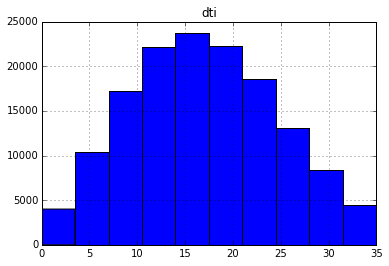

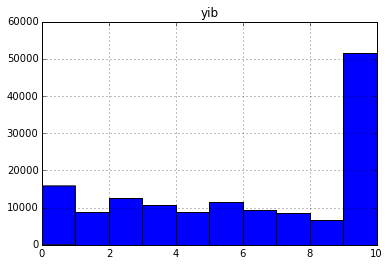

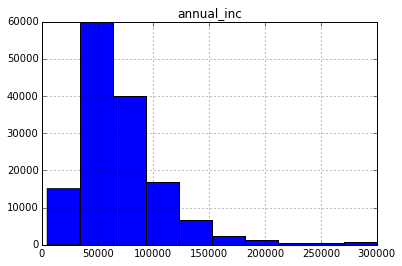

In [103]:
for col in colsEDA:
    lc2[col].hist()
    plt.title(col)
    plt.show()

#Start building the model!
Goal is to get a baseline as quickly as possible and fine tune from there. Looking to beat both FICO and Grade.

In [106]:
lc2.bad.value_counts()

0    125448
1     18738
dtype: int64

In [789]:
cols = ['annual_inc','dti','delinq_2yrs','fico_range_low','inq_last_6mths','mths_since_last_delinq',
        'mths_since_last_record','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'yib', 'bad']

In [790]:
lc3 = lc2[cols]

In [791]:
# y = lc3.pop('bad')

In [792]:
cat_vars = ['home_ownership', 'verification_status', 'purpose']

for var in cat_vars:
    lc2[var].fillna('missing', inplace=True)
    dummies = pd.get_dummies(lc2[var], prefix=var)
    lc3 = pd.concat([lc3,dummies],axis=1)

In [793]:
for col in cols[:-1]:
    lc3[col].fillna(lc3[col].mean(),inplace=True)

In [794]:
lc3['openRatio'] = lc3.open_acc.astype(float) / lc3.total_acc.astype(float)

In [795]:
# rerun with full dataset (only looking at > 24 months)
# why is inquiries unimportant in random forest?
# add more data - I don't think this is the problem bc the reg model works fine
# add more models (i.e. ensemble)
# create new variables from existing data (e.g. new var from job title)
# ratios - total acc to open acc
# create logistic regression model
# change to classification
# split of training data

In [800]:
lc3index = np.random.choice(lc3.index.values,len(lc3.index.values))
lc3train = lc3.ix[lc3index[:len(lc3index)*.8]]
lc3test = lc3.ix[lc3index[(len(lc3index)*.8)+1:]]

In [801]:
y = lc3train.pop('bad')
y2 = lc3test.pop('bad')
numFeats = len(lc3.columns)
model = RandomForestRegressor(n_estimators=100,max_features='auto', oob_score=False, random_state=42, n_jobs=-1) 
#max_features=numFeats
model.fit(lc3train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Since these are all approvals, very few are going to look bad enough to give a prediction over .5
because they would have been declined, that's why R and cstat are so bad
we are instead seeing how much better then FICO the model is

In [804]:
# y_oob = model.oob_prediction_ # these are the predictions
y_oob = model.predict(lc3test)
print 'c-stat: ', roc_auc_score(y2, y_oob)
# lc2['rfPreds'] = y_oob

c-stat:  0.898538423183


In [766]:
# numFeats = len(lc3.columns)
# model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1) 
# #max_features=numFeats
# model.fit(lc3, y)

In [767]:
imp = pd.DataFrame(lc3.columns.tolist(),model.feature_importances_)
imp = imp.reset_index()
imp.columns = ['imp', 'feat']
imp = imp.sort('imp',ascending=False)
top5cols = imp.feat.head(5).tolist()
# imp.head(100)

In [768]:
# lc2['rfClassPreds'] = model.oob_decision_function_[:,1]

In [769]:
# top5cols.append('inq_last_6mths')
lcLogReg = lc3.copy(deep=True)
# del lcLogReg['inq_last_6mths']
lcLogReg['int'] = 1

In [770]:
del lcLogReg['inq_last_6mths']

In [771]:
# YOU NEED TO ADD AN INTERCEPT IN LOG
logit = sm.Logit(y.values, lcLogReg)
res = logit.fit(maxiter=200)
lc2['logRegModel'] = res.predict()

Optimization terminated successfully.
         Current function value: 0.373537
         Iterations 8


In [772]:
# lcLogReg.head()

In [773]:
# res.summary2()

In [774]:
topWhat = int(len(lc2)*.5)

In [775]:
lc2 = lc2.sort(columns='rfPreds')
rfModelMean = lc2.head(topWhat).bad.mean()
lc2 = lc2.sort(columns='rfClassPreds',ascending=True)
rfClassModelMean = lc2.head(topWhat).bad.mean()
lc2 = lc2.sort(columns='fico_range_low', ascending=False)
ficoModelMean = lc2.head(topWhat).bad.mean()
lc2 = lc2.sort(columns='sub_grade', ascending=True)
lcModelMean = lc2.head(topWhat).bad.mean()
lc2 = lc2.sort(columns='logRegModel', ascending=True)
regModelMean = lc2.head(topWhat).bad.mean()
print datetime.utcnow()
print 'for the top ', topWhat, 'records:'
print 'rf model mean = ', rfModelMean
print 'rf class model mean = ', rfClassModelMean
print 'ficoModelMean mean = ', ficoModelMean
print 'lc mean = ', lcModelMean
print 'reg mean = ', regModelMean

2015-09-10 22:45:35.177221
for the top  72093 records:
rf model mean =  0.0
rf class model mean =  0.0981093864869
ficoModelMean mean =  0.100190032319
lc mean =  0.0845019627426
reg mean =  0.0871513184359


In [ ]:
# reg mean with inq =  0.0827680912155, without = 0.0871513184359 
# 2015-09-10 21:59:25.520668
# for the top  72093 records:
# rf model mean =  0.100869709958
# rf class model mean =  0.0977903541259
# ficoModelMean mean =  0.100287129125
# lc mean =  0.0841690594094
# reg mean =  0.121287781061, 0.123465523699

In [ ]:
# only numeric variables
# 2015-09-10 13:53:54.503581
# for the top  72093 records:
# rf model mean =  0.104878420929
# ficoModelMean mean =  0.100731000236
# lc mean =  0.0842938981593
# reg mean =  0.100536806625

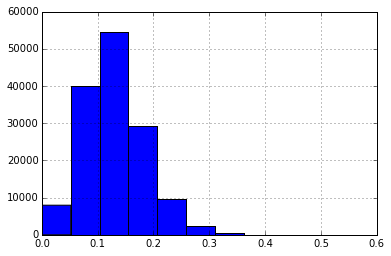

In [298]:
lc2.logRegModel.hist()

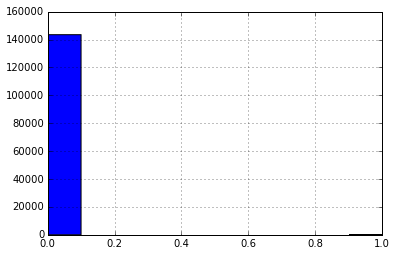

In [345]:
lcLogReg.purpose_vacation.hist()